# Antibiotic Resistance Gene Origin Predictor

In [14]:
# Genetic code table
CODON_TABLE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [15]:
from collections import defaultdict
import numpy as np
import pandas as pd

In [16]:
class CodonFeatureExtractor:
    """Extract codon usage features from DNA sequences"""

    def __init__(self):
        self.all_codons = [c for c in CODON_TABLE.keys() if CODON_TABLE[c] != "*"]

    def extract_codons(self, sequence):
        """Extract codons from sequence"""
        sequence = sequence.upper().replace('U', 'T')
        return [sequence[i:i+3] for i in range(0, len(sequence) - 2, 3) if len(sequence[i:i+3]) == 3]

    def calculate_codon_frequencies(self, sequence):
        """Calculate frequency of each codon"""
        codons = self.extract_codons(sequence)
        codon_counts = defaultdict(int)

        for codon in codons:
            if codon in CODON_TABLE and CODON_TABLE[codon] != '*':
                codon_counts[codon] += 1

        total = sum(codon_counts.values())
        if total == 0:
            return {codon: 0 for codon in self.all_codons}

        return {codon: codon_counts[codon] / total for codon in self.all_codons}

    def calculate_rscu(self, sequence):
        """Calculate Relative Synonymous Codon Usage"""
        codons = self.extract_codons(sequence)
        aa_codon_counts = defaultdict(lambda: defaultdict(int))

        # Count codons for each amino acid
        for codon in codons:
            if codon in CODON_TABLE and CODON_TABLE[codon] != '*':
                aa = CODON_TABLE[codon]
                aa_codon_counts[aa][codon] += 1

        # Calculate RSCU
        rscu_values = {}
        for aa, codon_counts in aa_codon_counts.items():
            if total_aa > 0:
                observed = codon_counts[codon]
                expected = total_aa / n_synonymous
                rscu_values[f'RSCU_{codon}'] = (observed / expected) if expected > 0 else 0
            else:
                rscu_values[f"RSCU_{codon}"] = 0

        return rscu_values

    def calculate_gc_content(self, sequence):
        """Calculate GC content metrics"""
        sequence = sequence.upper().replace('U', 'T')

        # Overall GC content
        gc_count = sequence.count('G') + sequence.count('C')
        gc_content = gc_count / len(sequence) if len(sequence) > 0 else 0

        # GC Content at third codon position (GC3)
        third_positions = sequence[2::3]
        gc3_count = third_positions.count('G') + third_positions.count('C')
        gc3_content = gc3_count / len(third_positions) if len(third_positions) > 0 else 0

        return {
            'GC_content': gc_content,
            'GC3_content': gc3_content,
            'AT_content': 1 - gc_content,
        }

    def calculate_enc(self, sequence):
        """Calculate Effective Number of Codons (ENC)"""
        codons = self.extract_codons(sequence)
        aa_codon_counts = defaultdict(lambda: defaultdict(int))

        for codon in codons:
            if codon in CODON_TABLE and CODON_TABLE[codon] != '*':
                aa = CODON_TABLE[codon]
                aa_codon_counts[aa][codon] += 1

        # Calculate homozygosity for each amino acid
        F_values = []
        for aa, codon_counts in aa_codon_counts.items():
            n = sum(codon_counts.values())
            if n > 0:
                F = sum((count / n) ** 2 for count in codon_counts.values())
                F_values.append(F)

        if not F_values:
            return 61   # Maximum Value

        F_mean = np.mean(F_values)
        enc = 2 + 9/F_mean + 1/(1-F_mean) if F_mean < 1 else 61

        return {'ENC': min(enc, 61)}

    def extract_all_features(self, sequence, gene_id='Unknown'):
        """Extract all features for a single sequence"""
        features = {"gene_id": gene_id}

        # Codon frequencies
        codon_freq = self.calculate_codon_frequencies(sequence)
        features.update(codon_freq)

        # GC Content
        gc_metrics = self.calculate_gc_content(sequence)
        features.update(gc_metrics)

        # ENC
        enc_metric = self.calculate_enc(sequence)
        features.update(enc_metric)

        # Sequence Length
        features['seq_length'] = len(sequence)

        return features
    


In [17]:
    # Initialize feature extractor
    print("\n[1/6] Initializing feature extractor...")
    extractor = CodonFeatureExtractor()


[1/6] Initializing feature extractor...


## Load Data

In [18]:
# Load data (you need to provide these files)
print("\n[2/6] Loading data...")
print("NOTE: You need to provide FASTA files:")
print("  - resistance_genes.fasta (known transferred resistance genes)")
print("  - native_genes.fasta (native housekeeping genes)")


[2/6] Loading data...
NOTE: You need to provide FASTA files:
  - resistance_genes.fasta (known transferred resistance genes)
  - native_genes.fasta (native housekeeping genes)


In [19]:
from Bio import SeqIO

In [20]:
def process_fasta_file(fasta_file, label, extractor):
    """Process FASTA file and extract features"""
    all_features = []

    for record in SeqIO.parse(fasta_file, 'fasta'):
        features = extractor.extract_all_features(str(record.seq), record.id)
        features['label'] = label
        features['organism'] = record.description.split('[')[1].split(']')[0] if '[' in record.description else 'unknown'
        all_features.append(features)

    return pd.DataFrame(all_features)

In [21]:
    # Process native genes
    df_native = process_fasta_file('data/native_genes.fasta', label=0, extractor=extractor)

    # Process resistance genes (transferred)
    df_resistance = process_fasta_file('data/resistance_genes.fasta', label=1, extractor=extractor)    
    
    # Combine datasets
    df = pd.concat([df_resistance, df_native], ignore_index=True)
    
    print(f"\nDataset shape: {df.shape}")
    print(f"Transferred genes: {(df['label']==1).sum()}")
    print(f"Native genes: {(df['label']==0).sum()}")


Dataset shape: (168, 69)
Transferred genes: 136
Native genes: 32


# Prepare Features and Labels

In [22]:
print("\n[3/6] Preparing features...")
feature_cols = [col for col in df.columns 
                if col not in ['gene_id', 'label', 'organism']]
X = df[feature_cols]
y = df['label']


[3/6] Preparing features...


In [23]:
X

,TTT,TTC,TTA,TTG,TCT,TCC,TCA,TCG,TAT,TAC,...,GAG,GGT,GGC,GGA,GGG,GC_content,GC3_content,AT_content,ENC,seq_length
0,0.003378,0.037162,0.003378,0.020270,0.006757,0.027027,0.006757,0.003378,0.016892,0.020270,...,0.016892,0.013514,0.020270,0.010135,0.000000,0.488215,0.616162,0.511785,22.150985,891
1,0.000000,0.051402,0.000000,0.002336,0.002336,0.009346,0.004673,0.009346,0.000000,0.009346,...,0.021028,0.011682,0.060748,0.025701,0.011682,0.684538,0.909091,0.315462,18.000779,1287
2,0.067686,0.017467,0.034934,0.026201,0.019651,0.010917,0.021834,0.008734,0.019651,0.000000,...,0.004367,0.019651,0.004367,0.054585,0.017467,0.343500,0.239651,0.656500,19.792666,1377
3,0.037037,0.017284,0.044444,0.039506,0.002469,0.012346,0.009877,0.004938,0.009877,0.004938,...,0.017284,0.046914,0.022222,0.029630,0.009877,0.465517,0.428571,0.534483,22.606303,1218
4,0.054863,0.014963,0.057357,0.032419,0.009975,0.000000,0.022444,0.017456,0.009975,0.007481,...,0.007481,0.032419,0.022444,0.019950,0.022444,0.432836,0.393035,0.567164,21.278554,1206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.006173,0.006173,0.003086,0.006173,0.012346,0.009259,0.033951,0.033951,0.003086,0.000000,...,0.003086,0.009259,0.027778,0.000000,0.021605,0.652000,0.660661,0.348000,20.763280,1000
164,0.012085,0.015106,0.000000,0.000000,0.009063,0.012085,0.006042,0.006042,0.000000,0.003021,...,0.021148,0.024169,0.045317,0.039275,0.024169,0.642000,0.570571,0.358000,21.541883,1000
165,0.006173,0.000000,0.000000,0.003086,0.009259,0.012346,0.003086,0.027778,0.006173,0.000000,...,0.000000,0.012346,0.021605,0.015432,0.018519,0.683000,0.528529,0.317000,19.449693,1000
166,0.006192,0.012384,0.003096,0.021672,0.018576,0.012384,0.006192,0.040248,0.003096,0.003096,...,0.003096,0.021672,0.040248,0.027864,0.015480,0.650000,0.588589,0.350000,20.695246,1000


In [24]:
y

0      1
1      1
2      1
3      1
4      1
      ..
163    0
164    0
165    0
166    0
167    0
Name: label, Length: 168, dtype: int64

## Split the Data

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
print("\n[4/6] Splitting data (80/20 train/test)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


[4/6] Splitting data (80/20 train/test)...


In [27]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 134 samples
Test set: 34 samples


## Train Models

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [33]:
def train_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple models"""

    # Standardize Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            random_state=123,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=123,
            eval_metrics='logloss'
        )
    }

    results = {}

    for name, model in models.items():
        print(f"\n\n\nTraining {name} ...\n\n")

        # Train
        if name == 'XGBoost':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

        # Evaluate
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # ROC-AUC
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"\nROC-AUC Score: {roc_auc:.4f}")
        
        # Cross-validation
        if name == 'Random Forest':
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        else:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
        print(f"Cross-validation F1 (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        
        # Store results
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'probabilities': y_proba,
            'roc_auc': roc_auc,
            'cv_scores': cv_scores
        }

                # Feature importance for Random Forest
        if name == 'Random Forest' and hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nTop 10 Most Important Features:")
            print(feature_importance.head(10).to_string(index=False))
            results[name]['feature_importance'] = feature_importance
    
    return results, scaler


In [34]:
print("\n[5/6] Training models...")
results, scaler = train_models(X_train, X_test, y_train, y_test)


[5/6] Training models...



Training Random Forest ...



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        28

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34


ROC-AUC Score: 1.0000
Cross-validation F1 (5-fold): 0.9776 (+/- 0.0144)

Top 10 Most Important Features:
   feature  importance
       TGC    0.103116
       CGC    0.071274
       ATG    0.066687
       CGT    0.063540
       AGG    0.060728
       CGA    0.055154
       CGG    0.049963
AT_content    0.039524
seq_length    0.037164
GC_content    0.034122



Training XGBoost ...




c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:06:27] WARNING: C:\actions-runner\_work\xgb


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.96      0.96      0.96        28

    accuracy                           0.94        34
   macro avg       0.90      0.90      0.90        34
weighted avg       0.94      0.94      0.94        34


ROC-AUC Score: 0.9821
Cross-validation F1 (5-fold): 0.9686 (+/- 0.0180)


c:\Users\shres\Projects\Learning-BioInformatics\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Visualization

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def plot_feature_importance(feature_importance, top_n=15):
    """Plot feature importance"""
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(top_n)
    
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Top {top_n} Most Important Features for Gene Origin Prediction')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("\nFeature importance plot saved as 'feature_importance.png'")


In [40]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Native', 'Transferred'],
                yticklabels=['Native', 'Transferred'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Confusion matrix plot saved as 'confusion_matrix.png'")



[6/6] Creating visualizations...


C:\Users\shres\AppData\Local\Temp\ipykernel_67576\2114695790.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')



Feature importance plot saved as 'feature_importance.png'
Confusion matrix plot saved as 'confusion_matrix.png'


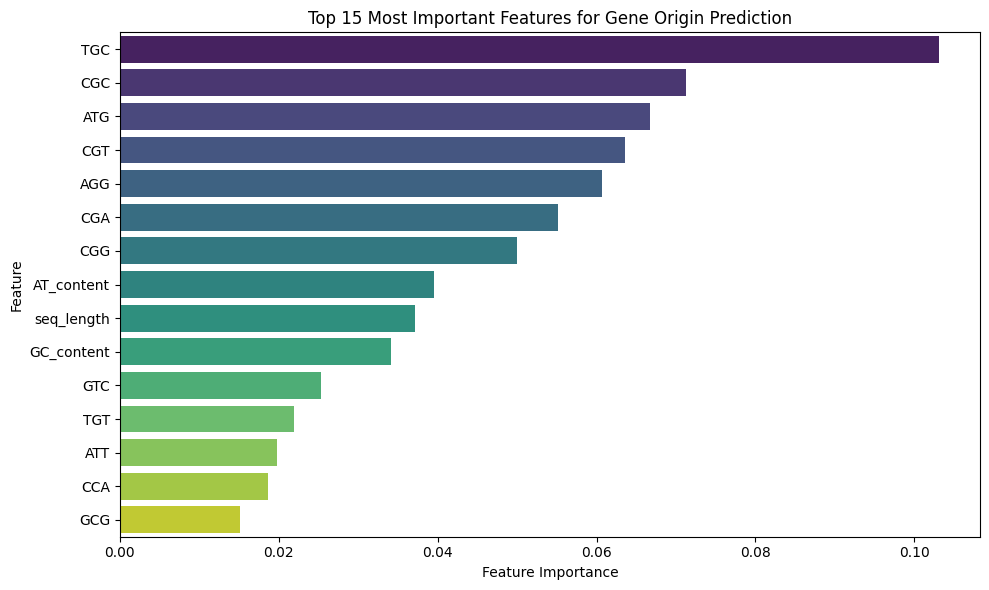

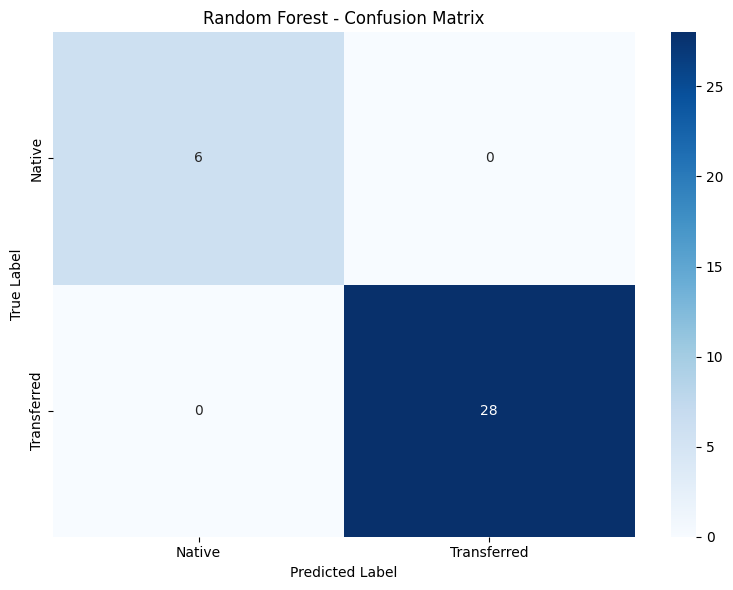

In [41]:
    print("\n[6/6] Creating visualizations...")
    if 'Random Forest' in results and 'feature_importance' in results['Random Forest']:
        plot_feature_importance(results['Random Forest']['feature_importance'])
    
    plot_confusion_matrix(y_test, results['Random Forest']['predictions'], 
                         'Random Forest - Confusion Matrix')

## Save Best Model

In [43]:
class ARGOPPredictor:
    """Complete prediction pipeline for new sequences"""
    
    def __init__(self, model, scaler, extractor):
        self.model = model
        self.scaler = scaler
        self.extractor = extractor
    
    def predict_single_gene(self, sequence, gene_id='unknown'):
        """Predict origin of a single gene"""
        # Extract features
        features = self.extractor.extract_all_features(sequence, gene_id)
        features_df = pd.DataFrame([features])
        
        # Remove non-feature columns
        feature_cols = [col for col in features_df.columns 
                       if col not in ['gene_id', 'label', 'organism']]
        X = features_df[feature_cols]
        
        # Scale if needed
        if self.scaler:
            X_scaled = self.scaler.transform(X)
            prediction = self.model.predict(X_scaled)[0]
            probability = self.model.predict_proba(X_scaled)[0]
        else:
            prediction = self.model.predict(X)[0]
            probability = self.model.predict_proba(X)[0]
        
        return {
            'gene_id': gene_id,
            'prediction': 'Transferred' if prediction == 1 else 'Native',
            'confidence': max(probability),
            'native_prob': probability[0],
            'transferred_prob': probability[1]
        }
    
    def predict_fasta(self, fasta_file):
        """Predict origin for all genes in FASTA file"""
        results = []
        
        for record in SeqIO.parse(fasta_file, "fasta"):
            result = self.predict_single_gene(str(record.seq), record.id)
            results.append(result)
        
        return pd.DataFrame(results)


In [44]:
# Save best model
print("\n[COMPLETE] Saving models...")
import pickle

best_model = results['Random Forest']['model']
predictor = ARGOPPredictor(best_model, None, extractor)

with open('argop_model.pkl', 'wb') as f:
    pickle.dump(predictor, f)

print("Model saved as 'argop_model.pkl'")


[COMPLETE] Saving models...
Model saved as 'argop_model.pkl'


## Prediction

In [45]:
# Example prediction
print("\n" + "="*70)
print("EXAMPLE PREDICTION")
print("="*70)

example_seq = "ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGCGGTAAGATCCTTGAGAGTTTTCGCCCCGAAGAACGTTTTCCAATGATGAGCACTTTTAAAGTTCTGCTATGTGGCGCGGTATTATCCCGTATTGACGCCGGGCAAGAGCAACTCGGTCGCCGCATACACTATTCTCAGAATGACTTGGTTGAGTACTCACCAGTCACAGAAAAGCATCTTACGGATGGCATGACAGTAAGAGAATTATGCAGTGCTGCCATAACCATGAGTGATAACACTGCGGCCAACTTACTTCTGACAACGATCGGAGGACCGAAGGAGCTAACCGCTTTTTTGCACAACATGGGGGATCATGTAACTCGCCTTGATCGTTGGGAACCGGAGCTGAATGAAGCCATACCAAACGACGAGCGTGACACCACGATGCCTGTAGCAATGGCAACAACGTTGCGCAAACTATTAACTGGCGAACTACTTACTCTAGCTTCCCGGCAACAATTAATAGACTGGATGGAGGCGGATAAAGTTGCAGGACCACTTCTGCGCTCGGCCCTTCCGGCTGGCTGGTTTATTGCTGATAAATCTGGAGCCGGTGAGCGTGGGTCTCGCGGTATCATTGCAGCACTGGGGCCAGATGGTAAGCCCTCCCGTATCGTAGTTATCTACACGACGGGGAGTCAGGCAACTATGGATGAACGAAATAGACAGATCGCTGAGATAGGTGCCTCACTGATTAAGCATTGGTAA"

result = predictor.predict_single_gene(example_seq, 'example_gene')
print(f"\nGene ID: {result['gene_id']}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Native probability: {result['native_prob']:.2%}")
print(f"Transferred probability: {result['transferred_prob']:.2%}")


EXAMPLE PREDICTION

Gene ID: example_gene
Prediction: Transferred
Confidence: 68.27%
Native probability: 31.73%
Transferred probability: 68.27%
